# **Project: AI-Generated Music Using Transformers and GANs**

# **Milestone 2: Aquire and Understand the Data**

For this project, we are mainily using the [Lakh MIDI Dataset v0.1](https://colinraffel.com/projects/lmd/). The entire dataset of **1.4GB** has been downloaded to our local machines, and a selected subset of **170MB** has been uploaded to Google Drive for easier sharing and collaboration. We also use [MidiCaps](https://huggingface.co/datasets/amaai-lab/MidiCaps) of **376MB** to get more information about the files in Lakh MIDI Dataset.

## **Lakh MIDI Data Set**

The [Lakh MIDI Dataset v0.1](https://colinraffel.com/projects/lmd/) (Raffel, 2016) is a collection of 176,581 unique MIDI files of symbolic music data, 45,129 of which have been matched and aligned to entries in the Million Song Dataset. The MIDI files were scraped from publicly available sources on the internet and then de-duplicated according to their MD5 checksum. We will start with a subset of the LMD-matched, which is a curated subset of the larger LMD-full MIDI collection containing 45,129 files. The subset we are using for this analysis contains 4166 files. Each file has been carefully "matched" to an entry in the Million Song Dataset (MSD). This matching allows you to connect symbolic music data (MIDI) with rich metadata and audio previews available in the MSD.

After downloading the data, it is split into alphabetical folders `A, B, ..., Z`. Inside of each of these folders is another group of alphabetical folders `A, B, ..., Z`, and there is one more nested layer after that again `A, B, ..., Z`. There is no structure to how MIDI files get mapped to one of these subdirectories, so, we chose one of them for our subset for this milestone. In the pre-processing, we ensure that all the corrupted, unreadable, or duplicates files are handled properly.

The LMD-matched subset provides structured metadata through its alignment with MSD, including fields like artist, title, and release year. However, this metadata is not directly relevant to our project. Instead, we use [MidiCaps](https://huggingface.co/datasets/amaai-lab/MidiCaps) dataset (Melechovsky, 2023) from HuggingFace, which offers more musically meaningful information about the MIDI files for music generation. MidiCaps is a textual `.json` file containing information such as instruments, genres, chords and tempo. This dataset corresponds to the full LMD data and may not perfectly align with matched LMD data.

The missing data in this dataset appears to be Missing Completely at Random (MCAR). Based on the Hugging Face Dataset's description, there was no targeted filtering to exclude music based on specific criteria such as genre, instrumentation, or popularity. This indicates that missing files or metadata likely result from random factors like file availability or scraping limitations, rather than systematic exclusion. To minimize issues from missing data, we perform an **inner join** between the MIDI note statistics and the MidiCaps data, ensuring that we only retain files present in both sources. Since the missingness is assumed to be MCAR, this approach should not introduce bias into our results or analyses.


Data imbalance is a known issue because different genres are not equally represented. Midi files are of different lengths which is a form of imbalance, this could potentially be addressed by padding, truncation or filtering of the files before input into the music generation model. The number of instruments in a song is also a potential form of imbalance but whether we will resolve it will likely depend on the performance of the music generation model. For instance if the generation is able to create the sounds of multiple instruments with ease we do not need to filter for it when generating a song for a specific genre. Whereas if we improve performance by filtering for a low instrument count, then we can consider this kind of preprocessing.

Since our end goal is to build a music generation model feature scaling is not directly applicable in the traditional sense because we are using symbolic music data. We will not be training the model on the textual meta data. Potential models like Transformers, LSTMs, and GANs for this application typically operate on discrete event sequences (e.g., note on/off events, pitch values, velocity changes, time shifts) that are either: tokenized into vocabulary-like inputs (e.g., MIDI-like or REMI format), or embedded via learned embeddings in the model. Each symbolic event is treated as a categorical token, and embeddings learn to represent relationships between these tokens. As a result, standard feature scaling techniques such as Z-score normalization or Min-Max scaling are not applicable or necessary. The model would learn high-level representations directly from token sequences, and any variance in scale is inherently captured through embeddings and temporal context modeling.

**References**

[1] Colin Raffel. "Learning-Based Methods for Comparing Sequences, with Applications to Audio-to-MIDI Alignment and Matching". PhD Thesis, 2016. https://colinraffel.com/projects/lmd/

[2] Jan Melechovsky, Abhinaba Roy, Dorien Herremans. "MidiCaps: A Large-Scale MIDI Dataset with Text Captions." arXiv preprint arXiv:2306.02541, 2023. https://arxiv.org/abs/2306.02541

## **Extract and Load Data**

### Import Libraries

In [41]:
!pip install pretty_midi
!pip install umap-learn

import os
import ast
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
import umap.umap_ as umap
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from itertools import chain
from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
# from google.colab import drive

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 17.4 MB/s eta 0:00:00a 0:00:01


### Mount Google Drive

In [3]:
# drive.mount('/content/drive', force_remount=True)

Next, create a shortcut in Google Drive to `ac209b_project` by right clicking on the folder, clicking Organize > Add shortcut.

### Copy & Extract Dataset

In [4]:
# # Set Drive and Local Paths
# drive_zip_path = "/content/drive/MyDrive/ac209b_project/data/test/I.zip"
# local_zip_path = "/content/I.zip"
# local_extract_dir = "/content/test"

# json_drive_path = "/content/drive/MyDrive/ac209b_project/data/midicaps_train.json"
# json_local_path = "/content/midicaps_train.json"

# csv_drive_path = "/content/drive/MyDrive/ac209b_project/data/merged_midi_data.csv"
# csv_local_path = "/content/merged_midi_data.csv"

# # Copy zip file from Drive to local if not already copied
# if not os.path.exists(local_zip_path):
#     print("Copying zip file from Drive...")
#     shutil.copy(drive_zip_path, local_zip_path)
#     print("Copied zip file from Drive.")
# else:
#     print("Zip file already copied to local session.")

# # Unzip only if not already extracted
# if not os.path.exists(local_extract_dir) or len(os.listdir(local_extract_dir)) == 0:
#     print("Extracting zip file...")
#     os.makedirs(local_extract_dir, exist_ok=True)
#     shutil.unpack_archive(local_zip_path, local_extract_dir)
#     print("Extraction complete.")
# else:
#     print("Data already extracted.")

# # Copy metadata files from Drive
# if not os.path.exists(json_local_path):
#     print("Copying JSON metadata...")
#     shutil.copy(json_drive_path, json_local_path)
#     print("Copied JSON metadata.")
# else:
#     print("JSON metadata already copied.")

# try:
#     if not os.path.exists(csv_local_path):
#         if os.path.exists(csv_drive_path):
#             print("Copying merged data from Drive...")
#             shutil.copy(csv_drive_path, csv_local_path)
#             print("Copied merged data.")
#     else:
#         print("CSV already copied to session.")
# except Exception as e:
#     print(f"Unexpected error while copying CSV: {e}")


In [10]:
local_zip_path = "./data/I.zip"
local_extract_dir = "./data/test"
csv_local_path = "./data/merged_midi_data.csv"

# Unzip only if not already extracted
if not os.path.exists(local_extract_dir) or len(os.listdir(local_extract_dir)) == 0:
    print("Extracting zip file...")
    os.makedirs(local_extract_dir, exist_ok=True)
    shutil.unpack_archive(local_zip_path, local_extract_dir)
    print("Extraction complete.")
else:
    print("Data already extracted.")

Data already extracted.


### Find Valid MIDI Files

In [11]:
midi_files = [
    os.path.join(dp, f)
    for dp, dn, filenames in os.walk(local_extract_dir)
    for f in filenames
    if f.endswith('.mid') and '/__MACOSX/' not in os.path.join(dp, f) and not f.startswith('._')
]
print(f"Found {len(midi_files)} MIDI files")

Found 4166 MIDI files


### Extract MIDI Note Statistics and Merge with Metadata

In [12]:
bad_files = []

def extract_note_stats(midi_file):
    """
    Extracts note statistics from a MIDI file using pretty_midi.

    Args:
        midi_file (str): Path to the MIDI file.

    Returns:
        dict or None: A dictionary containing statistics if the file is valid and contains notes:
            - 'filename' (str): The name of the MIDI file.
            - 'num_notes' (int): Total number of notes across all instruments.
            - 'duration_sec' (float): Duration of the MIDI file in seconds.
            - 'notes_per_sec' (float): Average number of notes per second.

        Returns None if the file has no notes or if an error occurs during parsing.

    Side Effects:
        Appends a tuple (midi_file, error_message) to the global bad_files list if an error occurs.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_count = sum(len(inst.notes) for inst in midi_data.instruments)
        duration = midi_data.get_end_time()

        if note_count > 0:
            return {
                'filename': os.path.basename(midi_file),
                'num_notes': note_count,
                'duration_sec': duration,
                'notes_per_sec': note_count / duration if duration > 0 else 0
            }
        else:
            return None
    except Exception as e:
        bad_files.append((midi_file, str(e)))
        return None

## Load the data

In [13]:
# Check if cached CSV exists in session
if os.path.exists(csv_local_path):
    print("Cached CSV found. Loading merged DataFrame...")
    df = pd.read_csv(csv_local_path)
    print("Loaded dataframe!")
else:
    print("No cached CSV found. Running full MIDI parsing and metadata merge...")

    stats = []
    bad_files = []

    for i, f in enumerate(midi_files):
        if i % 50 == 0:
            print(f"Processing file {i}/{len(midi_files)}")
        result = extract_note_stats(f)
        if result:
            stats.append(result)

    df_stats = pd.DataFrame(stats)
    print(f"Parsed {len(df_stats)} good files.")
    print(f"Skipped {len(bad_files)} bad files.")
    print(df_stats.head())

    # Load JSON metadata
    df_caps = pd.read_json(json_local_path, lines=True)
    df_caps['filename'] = df_caps['location'].apply(lambda x: x.split('/')[-1])

    # Merge with MIDI note statistics
    df = pd.merge(df_stats, df_caps, on='filename', how='inner')

    print(f"Merged shape: {df.shape}")

    # Save for future runs
    df.to_csv(csv_local_path, index=False)
    print("Saved merged DataFrame to session CSV.")

    # Show unmatched
    unmatched = df_stats[~df_stats['filename'].isin(df['filename'])]
    print(f"{len(unmatched)} MIDI files had no matching metadata.")

Cached CSV found. Loading merged DataFrame...
Loaded dataframe!


---

### Inspect Data

In [14]:
print("Column names:")
df.columns.tolist()

Column names:


['filename',
 'num_notes',
 'duration_sec',
 'notes_per_sec',
 'location',
 'caption',
 'genre',
 'genre_prob',
 'mood',
 'mood_prob',
 'key',
 'time_signature',
 'tempo',
 'tempo_word',
 'duration',
 'duration_word',
 'chord_summary',
 'chord_summary_occurence',
 'instrument_summary',
 'instrument_numbers_sorted',
 'all_chords',
 'all_chords_timestamps',
 'test_set']

### Sample Rows from the DataFrame

In [15]:
df.head()

,filename,num_notes,duration_sec,notes_per_sec,location,caption,genre,genre_prob,mood,mood_prob,...,tempo_word,duration,duration_word,chord_summary,chord_summary_occurence,instrument_summary,instrument_numbers_sorted,all_chords,all_chords_timestamps,test_set
0,564ad68aba73737f523e9b24c83694ca.mid,4433,185.450572,23.903944,lmd_full/5/564ad68aba73737f523e9b24c83694ca.mid,A lively pop song that radiates happiness and ...,"['pop', 'rock']","[0.42660000000000003, 0.24180000000000001]","['happy', 'motivational', 'melodic', 'corporat...","[0.2762, 0.1096, 0.0959, 0.0942, 0.0902]",...,Fast,185,Song,"['C', 'E', 'Bb', 'F']",9,"['Clean Electric Guitar', 'Acoustic Guitar', '...","[27, 25, 27, 29, 128, 5, 35, 34, 64]","['C', 'E', 'Bb', 'F', 'C', 'E', 'Bb', 'F', 'E'...","[0.464399092, 10.959818594, 12.724535147, 14.6...",False
1,a9d47ce588a28d8824ae3e556769d72a.mid,4433,185.449625,23.904066,lmd_full/a/a9d47ce588a28d8824ae3e556769d72a.mid,"This uplifting pop song, set in C major with a...","['pop', 'rock']","[0.4203, 0.2467]","['happy', 'motivational', 'melodic', 'corporat...","[0.27440000000000003, 0.11180000000000001, 0.0...",...,Allegro,185,Song,"['C', 'E', 'Bb', 'F']",9,"['Clean Electric Guitar', 'Acoustic Guitar', '...","[27, 25, 27, 29, 128, 5, 35, 34, 64]","['C', 'E', 'Bb', 'F', 'C', 'E', 'Bb', 'F', 'E'...","[0.464399092, 10.959818594, 12.724535147, 14.6...",False
2,f4b8996e0b322e88f71ce311692f6641.mid,3876,178.713147,21.688388,lmd_full/f/f4b8996e0b322e88f71ce311692f6641.mid,This energetic and melodic pop rock song radia...,"['pop', 'rock']","[0.3899, 0.3512]","['happy', 'melodic', 'energetic', 'motivationa...","[0.246, 0.1279, 0.1232, 0.0893, 0.0881]",...,Allegro,179,Song,"['C', 'Em', 'Bb']",6,"['Electric Guitar', 'Clean Electric Guitar', '...","[28, 27, 26, 33, 40, 128, 65]","['C', 'A/E', 'Edim', 'Bb', 'F', 'C7', 'A/E', '...","[0.464399092, 12.353015873, 13.560453514, 14.3...",False
3,354e9f7008c06423aeabbd2c347cea70.mid,4433,185.450572,23.903944,lmd_full/3/354e9f7008c06423aeabbd2c347cea70.mid,A joyful and motivational pop song featuring c...,"['pop', 'rock']","[0.42660000000000003, 0.24180000000000001]","['happy', 'motivational', 'melodic', 'corporat...","[0.2762, 0.1096, 0.0959, 0.0942, 0.0902]",...,Allegro,185,Song,"['C', 'E', 'Bb', 'F']",9,"['Clean Electric Guitar', 'Acoustic Guitar', '...","[27, 25, 27, 29, 128, 5, 35, 34, 64]","['C', 'E', 'Bb', 'F', 'C', 'E', 'Bb', 'F', 'E'...","[0.464399092, 10.959818594, 12.724535147, 14.6...",True
4,843790da9b021512e4929a3fb1046b2d.mid,4433,185.450572,23.903944,lmd_full/8/843790da9b021512e4929a3fb1046b2d.mid,"This uplifting pop song, set in C major with a...","['pop', 'rock']","[0.42660000000000003, 0.24180000000000001]","['happy', 'motivational', 'melodic', 'corporat...","[0.2762, 0.1096, 0.0959, 0.0942, 0.0902]",...,Allegro,185,Song,"['C', 'E', 'Bb', 'F']",9,"['Clean Electric Guitar', 'Acoustic Guitar', '...","[27, 25, 27, 29, 128, 5, 35, 34, 64]","['C', 'E', 'Bb', 'F', 'C', 'E', 'Bb', 'F', 'E'...","[0.464399092, 10.959818594, 12.724535147, 14.6...",False


In [16]:
print("\nSummary of missing values:")
df.isnull().sum()


Summary of missing values:


filename                     0
num_notes                    0
duration_sec                 0
notes_per_sec                0
location                     0
caption                      0
genre                        0
genre_prob                   0
mood                         0
mood_prob                    0
key                          2
time_signature               0
tempo                        9
tempo_word                   9
duration                     0
duration_word                0
chord_summary                0
chord_summary_occurence      0
instrument_summary           0
instrument_numbers_sorted    0
all_chords                   0
all_chords_timestamps        0
test_set                     0
dtype: int64

In [17]:
print("\nData types:")
df.dtypes


Data types:


filename                      object
num_notes                      int64
duration_sec                 float64
notes_per_sec                float64
location                      object
caption                       object
genre                         object
genre_prob                    object
mood                          object
mood_prob                     object
key                           object
time_signature                object
tempo                        float64
tempo_word                    object
duration                       int64
duration_word                 object
chord_summary                 object
chord_summary_occurence        int64
instrument_summary            object
instrument_numbers_sorted     object
all_chords                    object
all_chords_timestamps         object
test_set                        bool
dtype: object

## **Preprocessing**

### Data Cleaning

After merging the MIDI note statistics with metadata, the resulting DataFrame included 23 columns. Several of these were either redundant or not useful for our modeling goals. Specifically, we removed:

- `location`: file path in the original LMD structure (redundant with `filename`)
- `duration`: integer version of `duration_sec` (less precise)
- `duration_word`: a human-friendly label (e.g., "Song") that doesn't offer meaningful variance
- `test_set`: a predefined flag that we will replace with our own splits later

In addition, we encountered a small number of rows with missing values in the `key` and `tempo` columns. Since these represented a very small proportion of the data (<1%), we opted to simply drop these rows using `dropna()`. This avoids introducing any bias through imputation and simplifies preprocessing.

In [18]:
df = df.drop(columns=[
    'location', 'duration', 'duration_word', 'test_set'
])

df = df.dropna(subset=['key', 'tempo'])

print(f"{len(df)} samples in df")

3976 samples in df


The cleaned dataset retains the following columns, each of which is relevant for either musical structure, genre/mood classification, or caption-based modeling:

- `filename`: Unique name of the MIDI file
- `num_notes`: Total number of note events in the MIDI file
- `duration_sec`: Total duration of the piece in seconds
- `notes_per_sec`: Density of notes over time (can be used to identify sparse or very dense pieces)
- `caption`: Textual description of the music (from the MidiCaps dataset), useful for aligning text and symbolic music
- `genre`: List of genre labels associated with the piece (multi-label)
- `mood`: List of mood descriptors (multi-label)
- `key`: The musical key (e.g., C major, A minor) — useful for tonal analysis
- `time_signature`: The time signature (e.g., 4/4, 6/8) — relevant for rhythmic modeling
- `tempo`: Estimated tempo in beats per minute (BPM)
- `tempo_word`: A qualitative description of tempo (e.g., "Allegro", "Moderate")
- `chord_summary`: Summary of the main chords used in the piece
- `chord_summary_occurence`: Number of distinct chord changes in the summary
- `instrument_summary`: List of instruments used in the piece
- `instrument_numbers_sorted`: MIDI program numbers representing the instruments used

These features provide a well-rounded view of each song, spanning symbolic structure, genre/mood classification, instrument arrangement, and human-interpretable captions — all of which support downstream tasks like music generation, genre classification, or text-to-music alignment.


### Data Imbalance

- **Genre Imbalance:** A small set of genres (`pop`, `electronic`, `rock`) dominate the dataset, while others like `jazz`, `folk`, and `reggae` appear far less frequently. However, because we are performing music generation (not classification), we choose to retain all genres to preserve stylistic diversity.

- **Mood Imbalance:** Similar to genre, moods like `melodic`, `happy`, and `relaxing` are highly frequent, while others like `action` and `background` are rare. These labels are kept as-is for expressive diversity, but may be up/downsampled during conditional generation.

- **Note Counts & Density:** The `num_notes` and `notes_per_sec` distributions are skewed, with most songs clustering in moderate complexity but a long tail of very dense or sparse compositions. Similarly, `duration_sec` shows most tracks are between 100-300 seconds, with a few longer outliers.

- **Number of Instruments:** While most tracks use between 60 and 90 instruments (likely due to percussive or multitrack encoding in MIDI), there is still variance. These factors could influence generation difficulty.

Our strategy going forward is to:

- **Keep rare genres/moods:** To support creative and stylistic variety in generation.
- **Embed genre/mood:** Use learned embeddings rather than fixed labels to allow the model to generalize relationships between tags.
- **Sample-aware training:** We may balance batches during training to avoid overfitting to dominant tags (e.g., "pop" + "melodic").
- **Filtering:** We might filter out extreme outliers (e.g., >100 instruments or >20,000 notes) if they degrade training quality.

In [19]:
# Step 1: Convert stringified lists to actual Python lists
df['genre'] = df['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['mood'] = df['mood'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Normalize to lowercase, deduplicate, and strip whitespace
df['genre'] = df['genre'].apply(lambda tags: sorted(set(t.strip().lower() for t in tags)))
df['mood'] = df['mood'].apply(lambda tags: sorted(set(t.strip().lower() for t in tags)))

# Step 3: Flatten and count
from collections import Counter

genre_counter = Counter([g for sublist in df['genre'] for g in sublist])
mood_counter = Counter([m for sublist in df['mood'] for m in sublist])

print(f"Number of unique genres: {len(genre_counter)}")
print(f"Number of unique moods: {len(mood_counter)}")

print("\nTop 10 genres:")
print(genre_counter.most_common(10))

print("\nTop 10 moods:")
print(mood_counter.most_common(10))

Number of unique genres: 26
Number of unique moods: 40

Top 10 genres:
[('pop', 2367), ('electronic', 2189), ('rock', 1064), ('soundtrack', 659), ('classical', 654), ('ambient', 598), ('dance', 109), ('easylistening', 98), ('instrumentalpop', 79), ('jazz', 28)]

Top 10 moods:
[('melodic', 3299), ('happy', 2253), ('relaxing', 1909), ('christmas', 1654), ('film', 1276), ('motivational', 1053), ('love', 1019), ('corporate', 971), ('meditative', 942), ('energetic', 907)]


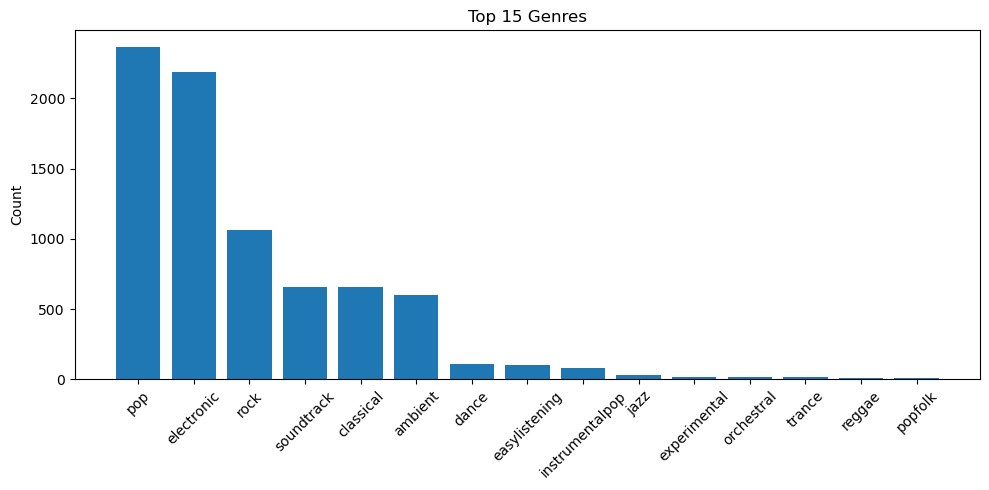

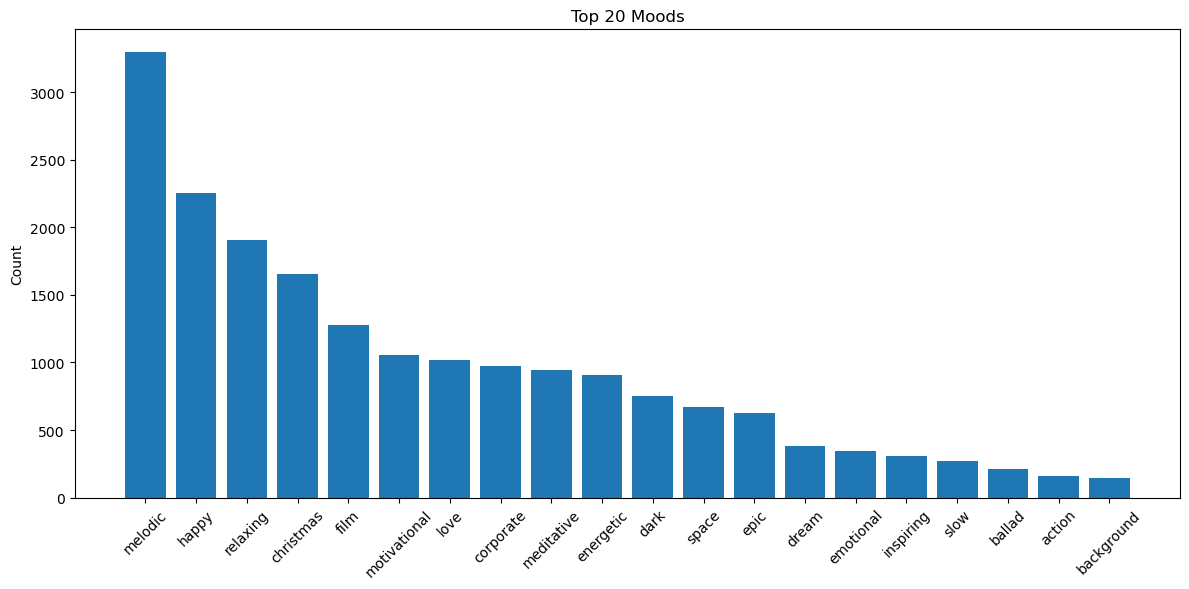

In [20]:
# Plot genres
top_genres = genre_counter.most_common(15)
plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_genres))
plt.xticks(rotation=45)
plt.title("Top 15 Genres")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot moods
top_moods = mood_counter.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_moods))
plt.xticks(rotation=45)
plt.title("Top 20 Moods")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

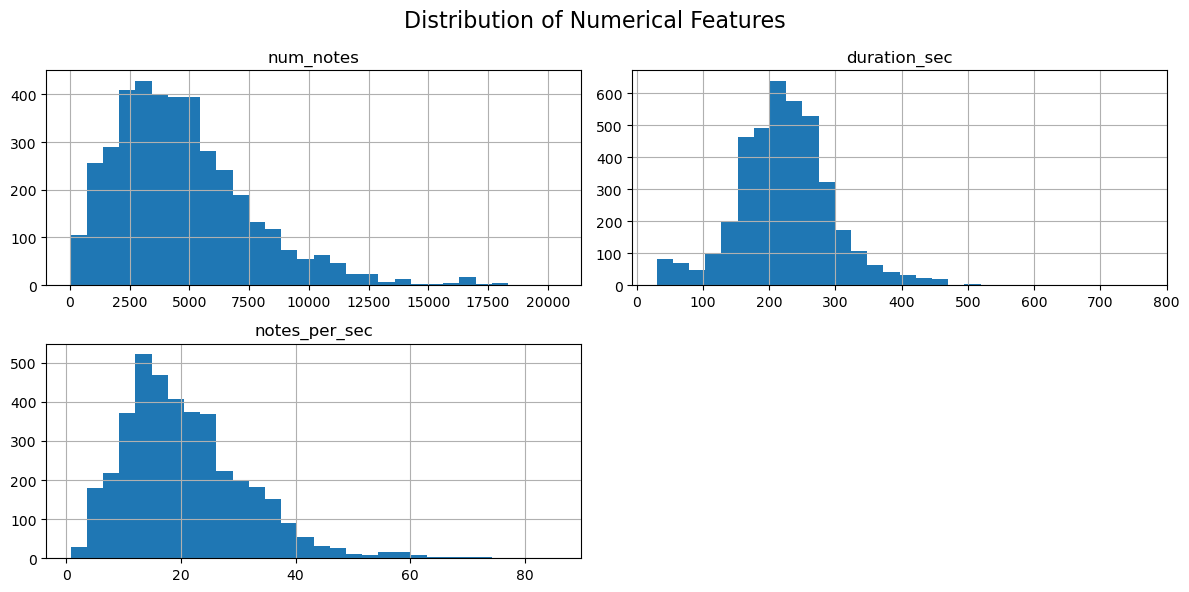

In [21]:
df[['num_notes', 'duration_sec', 'notes_per_sec']].hist(bins=30, figsize=(12, 6))
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

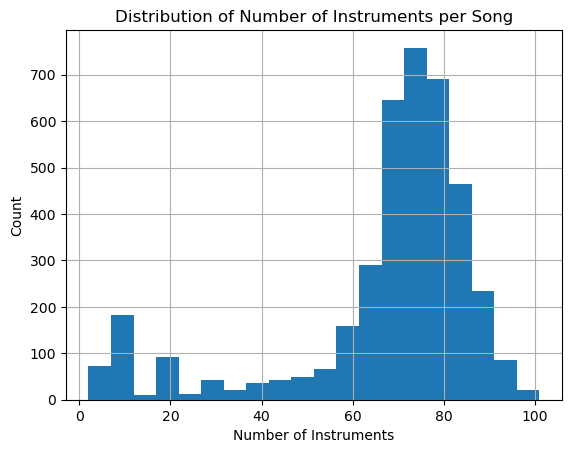

In [22]:
# How many instruments are used per song?
df['instrument_count'] = df['instrument_summary'].apply(len)

df['instrument_count'].hist(bins=20)
plt.title("Distribution of Number of Instruments per Song")
plt.xlabel("Number of Instruments")
plt.ylabel("Count")
plt.show()

Our dataset includes three primary numerical features:

- `num_notes`: total number of note events
- `duration_sec`: total song duration
- `notes_per_sec`: note density

These features are moderately skewed and operate on very different scales. In a traditional ML context this would require normalization or standardization.

However, because we are building a **sequence-based music generation model**, we expect the model to operate on tokenized symbolic inputs (e.g., note events, instrument codes). In such a setting:

- These numerical features may not be directly used
- If we condition on continuous values (e.g., tempo or note density), we can normalize at model input time

As a result, we defer feature scaling until we confirm their use as conditioning features in the model.

---

# EDA

## Song Length Distribution
To begin with, we can get an idea of the type of MIDI files which are available by looking at their length (i.e. time in seconds). MIDI files are variously used for storing short melodic fragmets, drum patterns, ringtones, and full-song transcriptions; looking at the distribution of lengths of MIDI files in our collection gives a rough picture of how common each of these uses is.

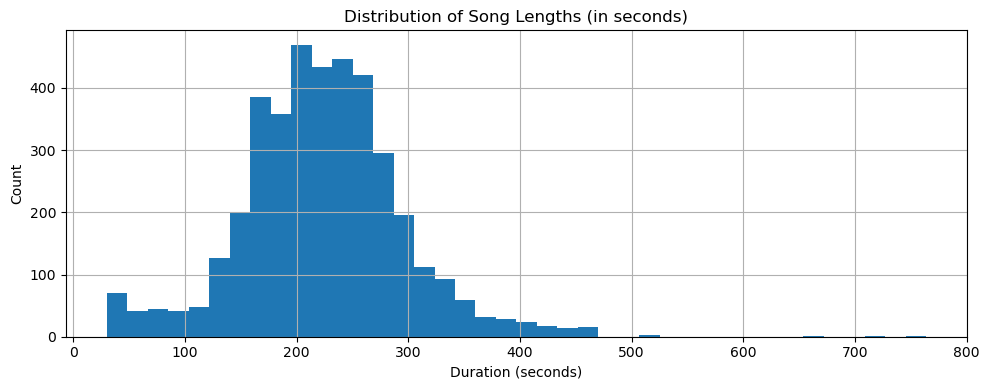

In [23]:
df['duration_sec'].hist(bins=40, figsize=(10, 4))
plt.title("Distribution of Song Lengths (in seconds)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

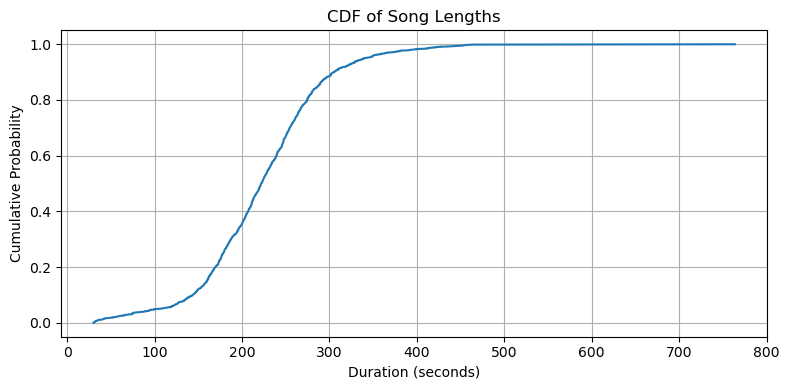

In [24]:
sorted_lengths = np.sort(df['duration_sec'])
cdf = np.arange(len(sorted_lengths)) / float(len(sorted_lengths))

plt.figure(figsize=(8, 4))
plt.plot(sorted_lengths, cdf)
plt.xlabel("Duration (seconds)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Song Lengths")
plt.grid(True)
plt.tight_layout()
plt.show()

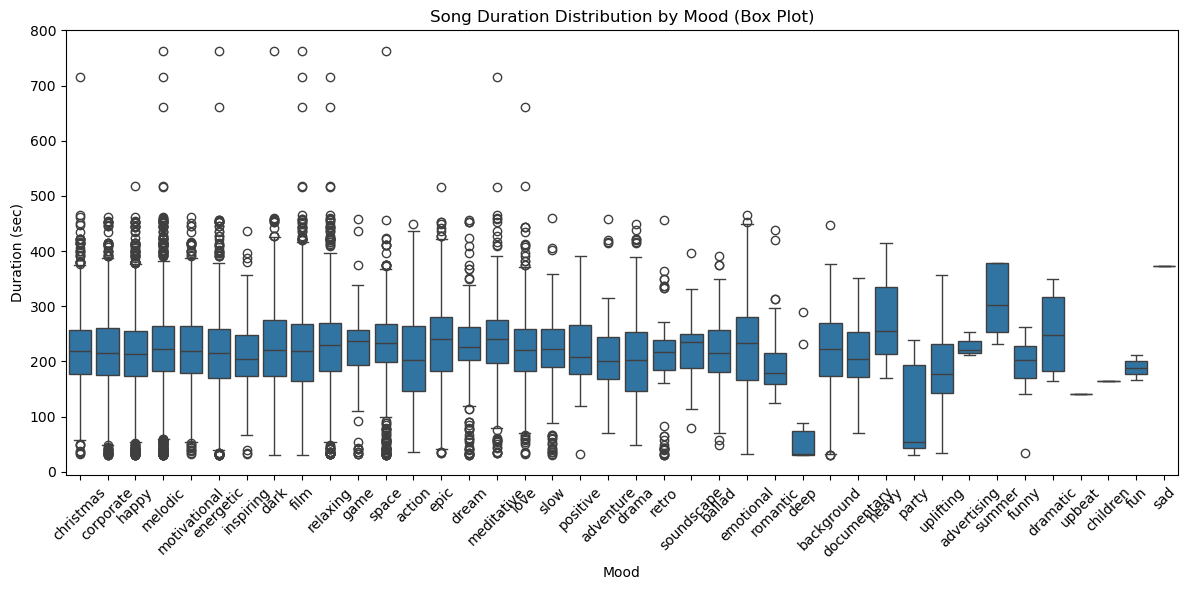

In [25]:
df['mood'] = df['mood'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_exploded = df.explode('mood')

plt.figure(figsize=(12, 6))
sns.boxplot(x='mood', y='duration_sec', data=df_exploded)
plt.xticks(rotation=45)
plt.title('Song Duration Distribution by Mood (Box Plot)')
plt.xlabel('Mood')
plt.ylabel('Duration (sec)')
plt.tight_layout()
plt.show()


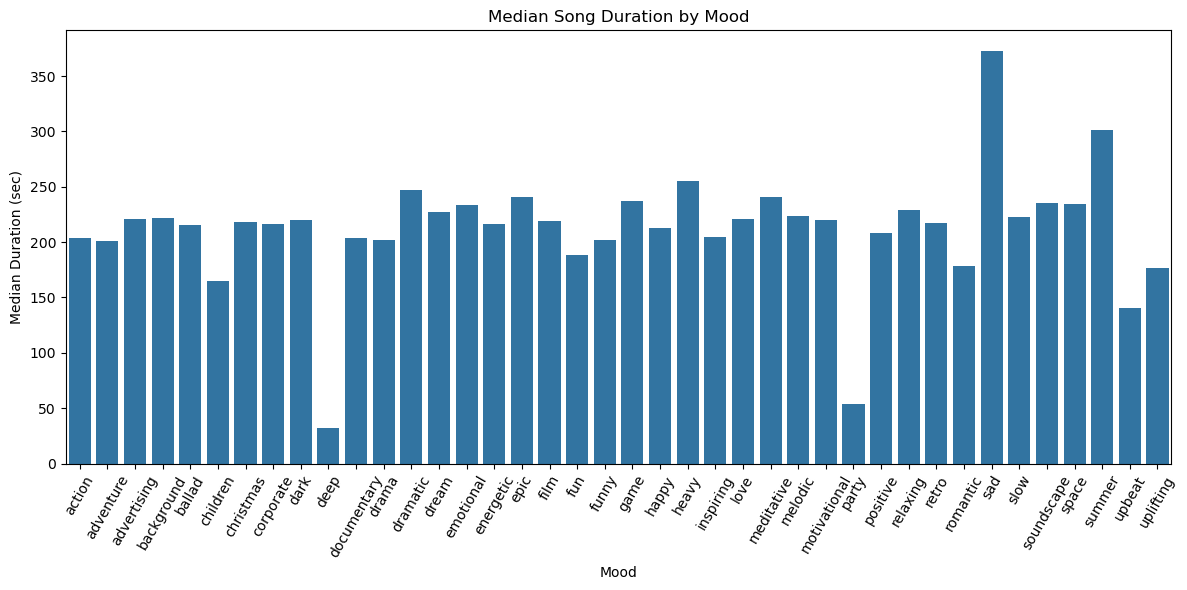

In [26]:
def prepare_multilabel_column(df, col):

    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df.explode(col)

df_mood = prepare_multilabel_column(df.copy(), 'mood')

mood_median_duration = df_mood.groupby('mood')['duration_sec'].median().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='mood', y='duration_sec', data=mood_median_duration)
plt.xticks(rotation=60)
plt.title('Median Song Duration by Mood')
plt.xlabel('Mood')
plt.ylabel('Median Duration (sec)')
plt.tight_layout()
plt.show()

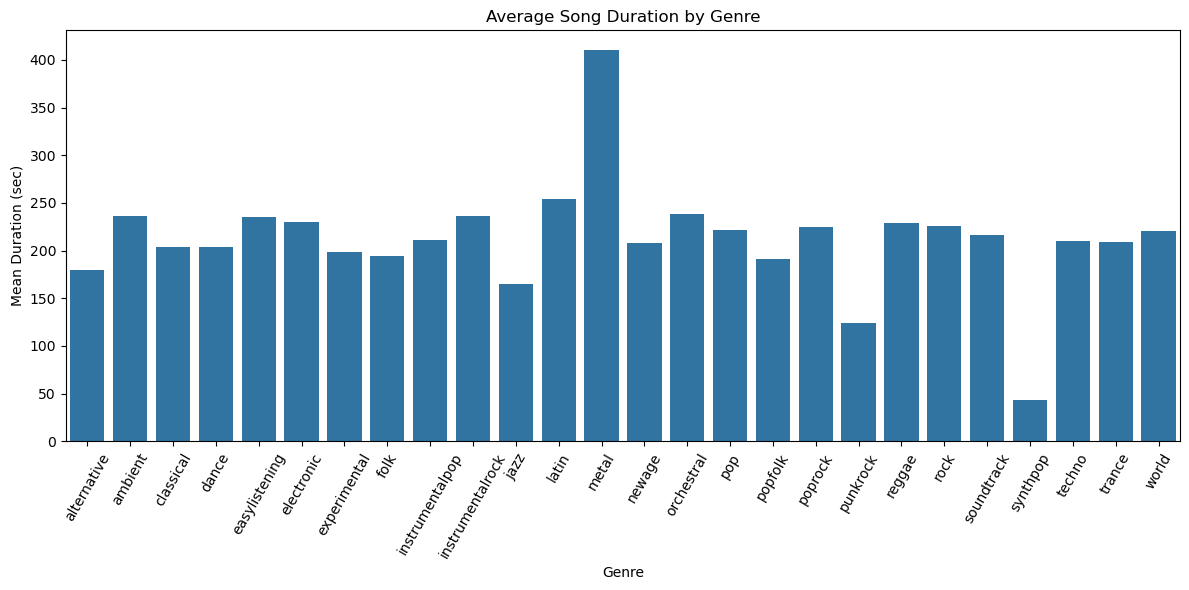

In [27]:
df_genre = prepare_multilabel_column(df.copy(), 'genre')

genre_mean_duration = df_genre.groupby('genre')['duration_sec'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='duration_sec', data=genre_mean_duration)
plt.xticks(rotation=60)
plt.title('Average Song Duration by Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Duration (sec)')
plt.tight_layout()
plt.show()

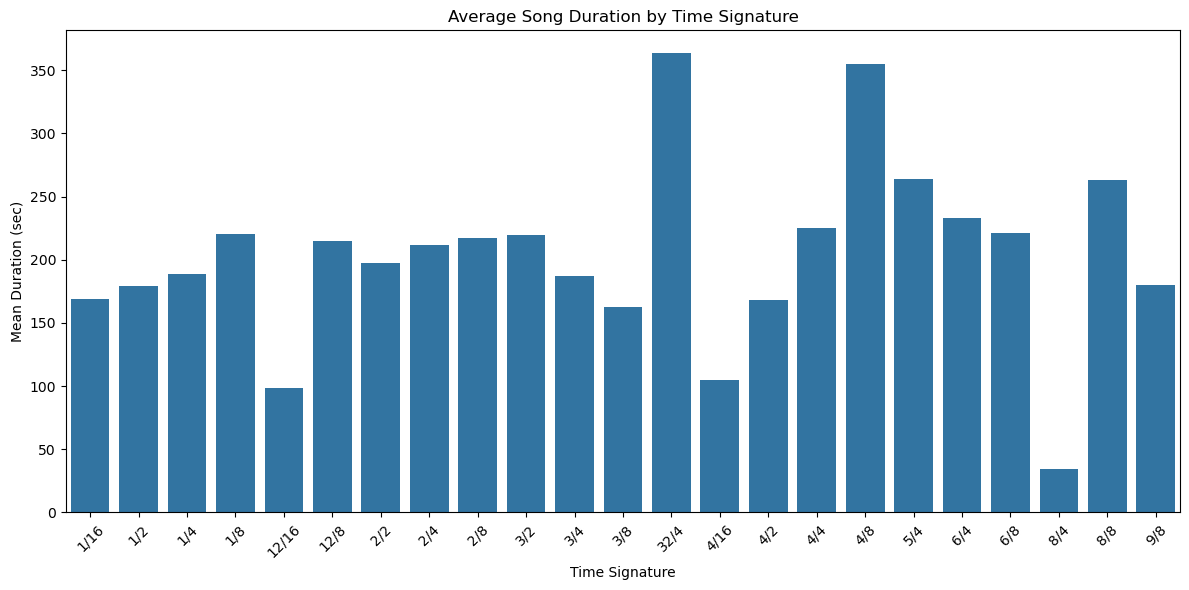

In [28]:
time_sig_mean_duration = df.groupby('time_signature')['duration_sec'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='time_signature', y='duration_sec', data=time_sig_mean_duration)
plt.xticks(rotation=45)
plt.title('Average Song Duration by Time Signature')
plt.xlabel('Time Signature')
plt.ylabel('Mean Duration (sec)')
plt.tight_layout()
plt.show()

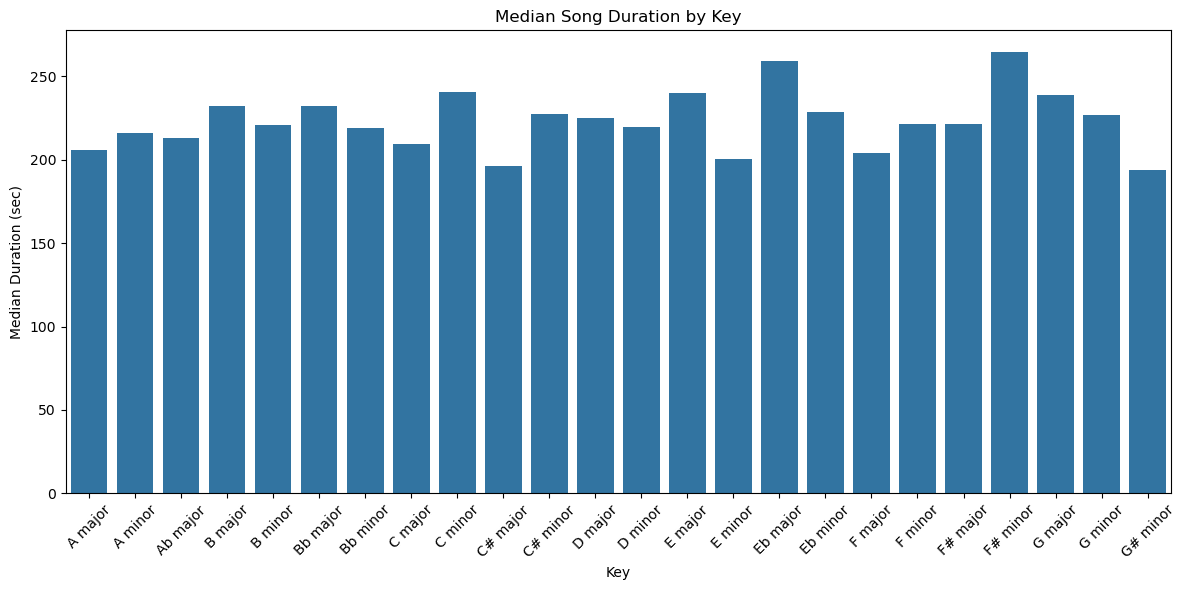

In [29]:
key_median_duration = df.groupby('key')['duration_sec'].median().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='key', y='duration_sec', data=key_median_duration)
plt.xticks(rotation=45)
plt.title('Median Song Duration by Key')
plt.xlabel('Key')
plt.ylabel('Median Duration (sec)')
plt.tight_layout()
plt.show()

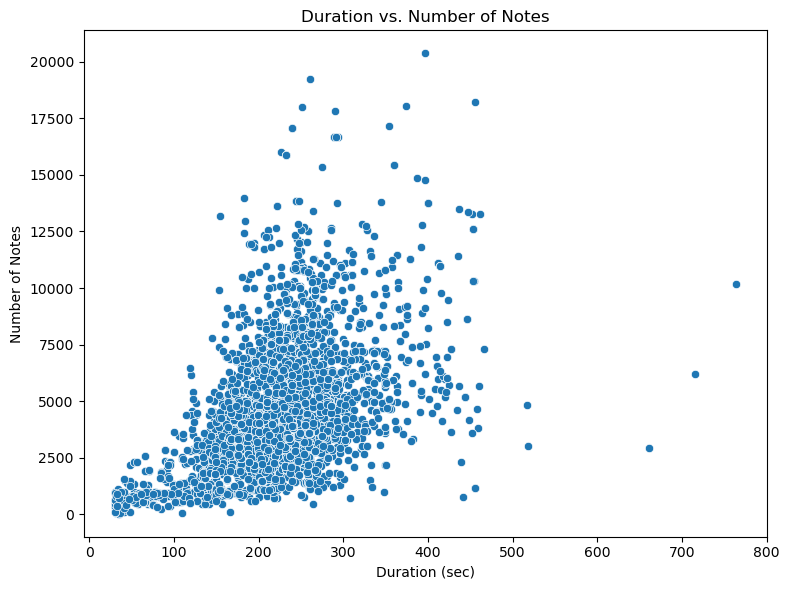

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='duration_sec', y='num_notes', data=df)
plt.title('Duration vs. Number of Notes')
plt.xlabel('Duration (sec)')
plt.ylabel('Number of Notes')
plt.tight_layout()
plt.show()

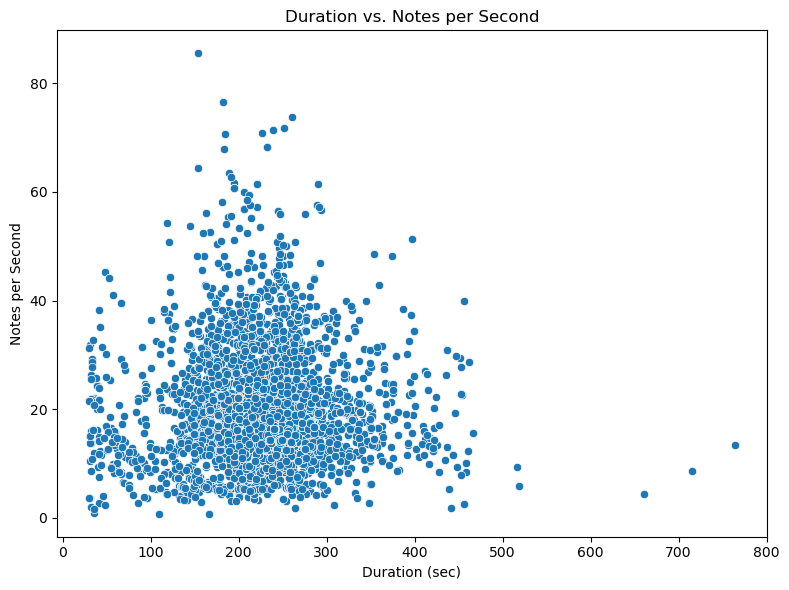

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='duration_sec', y='notes_per_sec', data=df)
plt.title('Duration vs. Notes per Second')
plt.xlabel('Duration (sec)')
plt.ylabel('Notes per Second')
plt.tight_layout()
plt.show()

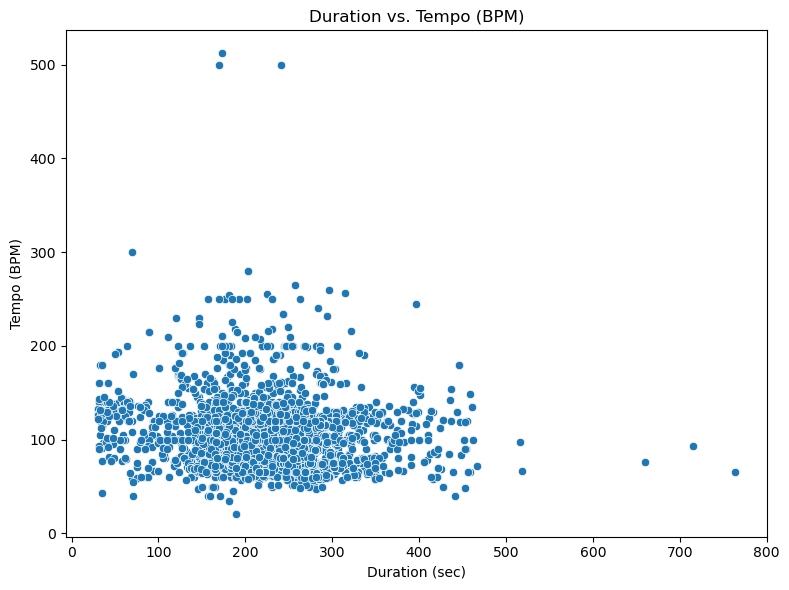

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='duration_sec', y='tempo', data=df)
plt.title('Duration vs. Tempo (BPM)')
plt.xlabel('Duration (sec)')
plt.ylabel('Tempo (BPM)')
plt.tight_layout()
plt.show()

## Instrument Distribution
In their simplest form, MIDI files contain a collection of notes played on a collection of instruments. Under the General MIDI specification, 128 instruments are available (see `pretty_midi.INSTRUMENT_MAP` for a list) which are indexed by their "program number". The distribution of the number of instruments in our MIDI files gives us further intuition into the MIDI files' usage; the distribution of program numbers shows us which instruments are more or less popular. The four most common program numbers (shown as the four tallest bars in the distribution of program numbers) were 0 (“Acoustic Grand Piano”), 48 (“String Ensemble 1”), 33 (“Electric Bass (finger)”), and 25 (“Acoustic Guitar (steel)”).

In [33]:
def clean_instrument_list(instr_list):
    # Ensure list and filter to integers only
    return [int(i) for i in instr_list if isinstance(i, int) or (isinstance(i, str) and i.isdigit())]

df['instrument_numbers_sorted'] = df['instrument_numbers_sorted'].apply(clean_instrument_list)

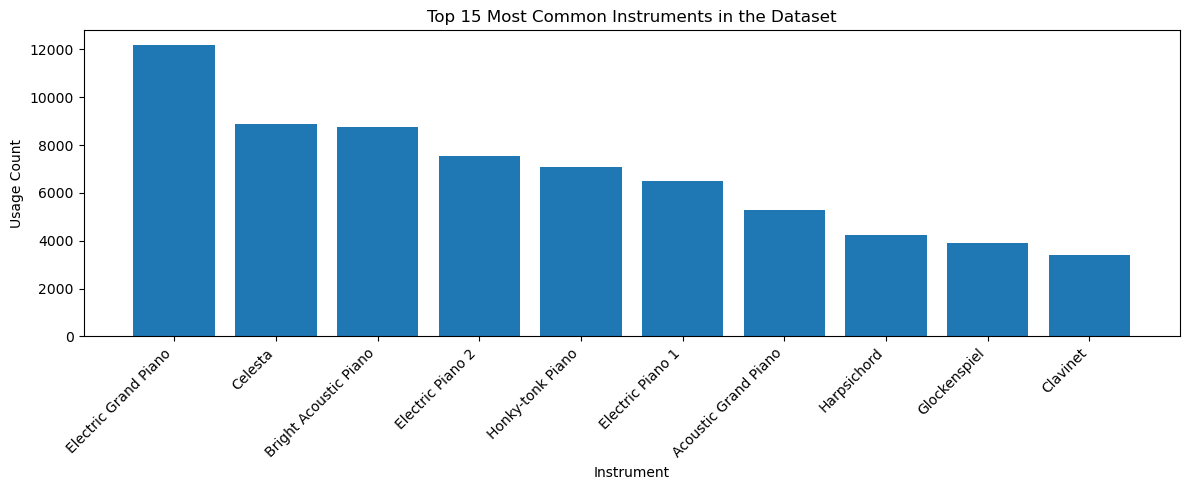

In [34]:
# Flatten and count instrument usage
instrument_counts = Counter(chain.from_iterable(df['instrument_numbers_sorted']))
top_instruments = instrument_counts.most_common(15)

# Map program number to instrument name
instrument_names = {i: pretty_midi.program_to_instrument_name(i) for i in range(128)}
instrument_labels = [instrument_names.get(p[0], f"Program {p[0]}") for p in top_instruments]
counts = [p[1] for p in top_instruments]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(instrument_labels, counts)
plt.title("Top 15 Most Common Instruments in the Dataset")
plt.xlabel("Instrument")
plt.ylabel("Usage Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Instrument Usage Patterns

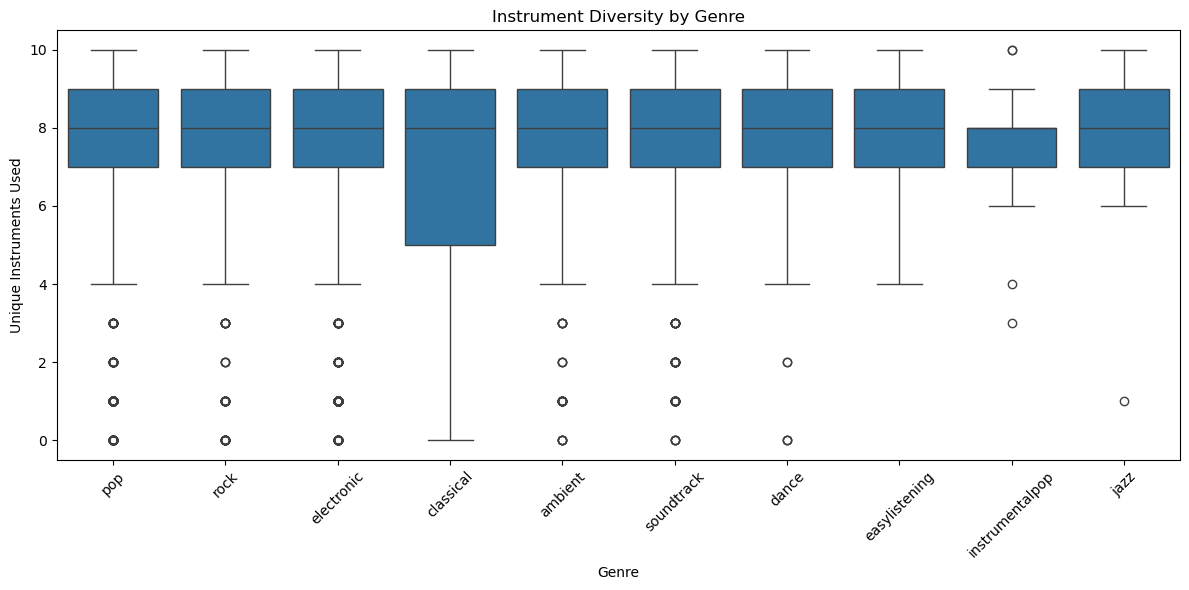

In [35]:
#Instrument Usage Patterns

# Instrument Diversity by Genre
# Unique instruments used per song.
# how diverse instrument combinations are within each genre — not just how many instruments are used, but how much variation exists between songs.
df['instrument_diversity'] = df['instrument_numbers_sorted'].apply(lambda x: len(set(x)))

# Explode genre and filter top genres
df_diversity = df.explode('genre')
top_genres = df_diversity['genre'].value_counts().head(10).index
df_diversity = df_diversity[df_diversity['genre'].isin(top_genres)]

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_diversity, x='genre', y='instrument_diversity')
plt.title("Instrument Diversity by Genre")
plt.xlabel("Genre")
plt.ylabel("Unique Instruments Used")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* Genres like ambient, soundtrack, and instrumentalpop show higher median and wider spread in instrument diversity, indicating richer, more complex arrangements.
*  Pop, jazz, and rock exhibit lower and tighter distributions, suggesting more standardized instrumentation.
* This variation highlights the importance of conditioning AI models on genre when generating music — genres differ not just in style, but in expected instrumental complexity.


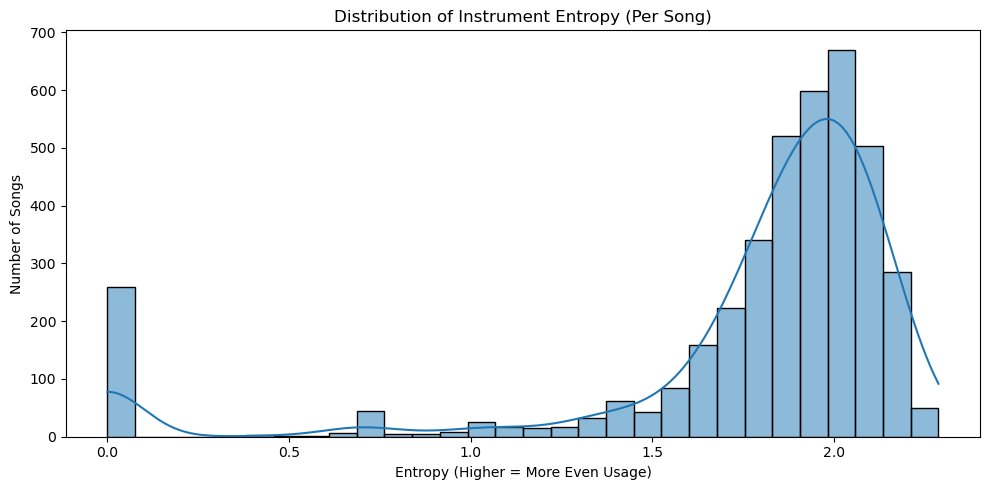

In [36]:
# Instrument Entropy (Per Song Complexity)
# Measures how spread out the instrument usage is — are all instruments used equally or is it dominated by one?
from scipy.stats import entropy

def compute_entropy(instr_list):
    counts = pd.Series(instr_list).value_counts()
    probs = counts / counts.sum()
    return entropy(probs)

df['instrument_entropy'] = df['instrument_numbers_sorted'].apply(compute_entropy)

plt.figure(figsize=(10, 5))
sns.histplot(df['instrument_entropy'], bins=30, kde=True)
plt.title("Distribution of Instrument Entropy (Per Song)")
plt.xlabel("Entropy (Higher = More Even Usage)")
plt.ylabel("Number of Songs")
plt.tight_layout()
plt.show()


This plot shows the distribution of instrument entropy per song, where higher entropy indicates more even use of instruments. Most songs cluster around moderate to high entropy, but a notable number use just one instrument (entropy near 0), suggesting a mix of rich and minimal instrumentation. This insight is useful for understanding variability in instrument usage and informs whether instrumentation alone can help distinguish genres or guide model features.

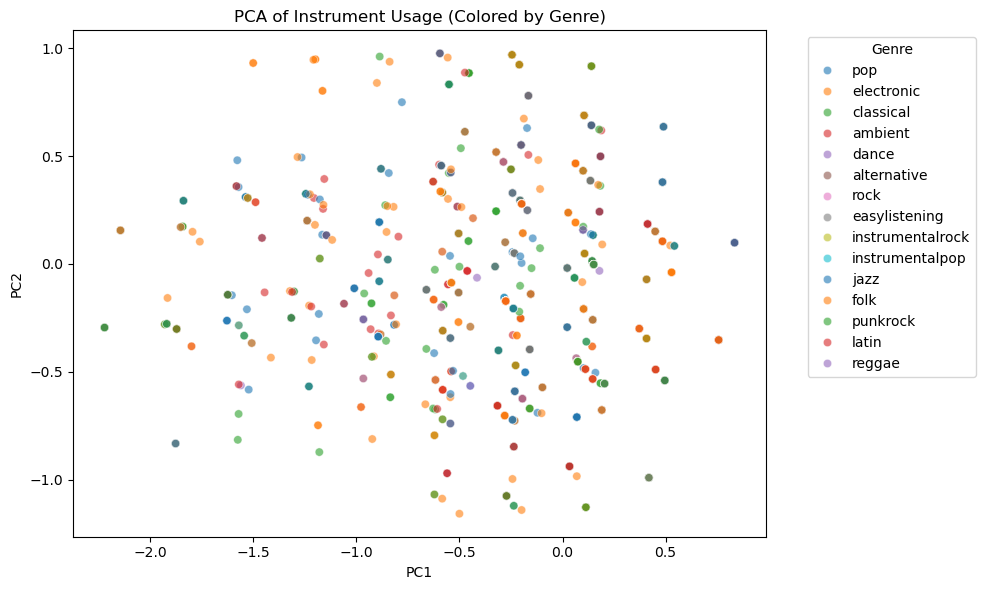

In [37]:
# Principal Components of Instrument Usage

# Hidden patterns — are genres linearly separable based on instrumentation alone?
from sklearn.decomposition import PCA

# Multilabel binarize instruments
mlb_instr = MultiLabelBinarizer()
instr_matrix = mlb_instr.fit_transform(df['instrument_numbers_sorted'])

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(instr_matrix)

# Add to DataFrame
df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
df_pca['genre'] = df['genre'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "unknown")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='genre', palette='tab10', alpha=0.6)
plt.title("PCA of Instrument Usage (Colored by Genre)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title='Genre')
plt.tight_layout()
plt.show()


This PCA plot presents significant overlap among genres based on instrument usage, suggesting that instrumentation alone may not linearly separate genres well. However, subtle clustering hints at latent patterns that more complex models might capture. However, this EDA insight informs us that additional features or non-linear approaches may be necessary for effective genre classification.

ValueError: Could not interpret value `Dim1` for `x`. An entry with this name does not appear in `data`.

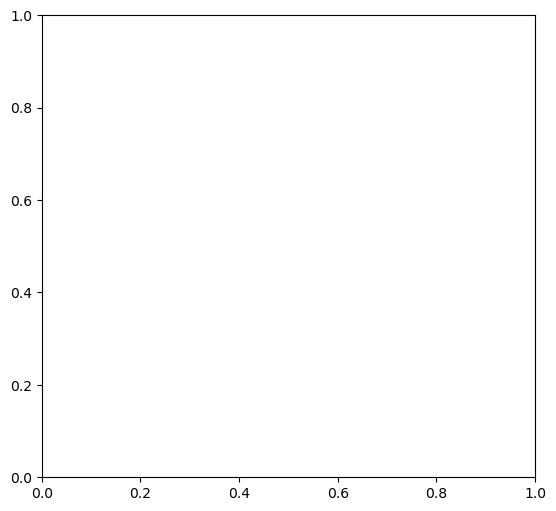

In [44]:
# Prepare data for dimensionality reduction visualization
# First, create t-SNE and UMAP components from instrument data (not shown in this cell)
# Then prepare dataframes with proper column names that match what we're using in the plot

# Create copies of the dataframe with exploded genre column
df_tsne_exploded = df.explode('genre').copy()
df_umap_exploded = df.explode('genre').copy()

# Ensure column names match exactly what we're using in the plot
# Assuming we have t-SNE and UMAP components stored in these columns
if 'PC1' in df_pca:
    df_tsne_exploded['Dim1'] = df_pca['PC1']
    df_tsne_exploded['Dim2'] = df_pca['PC2']
    df_umap_exploded['Dim1'] = df_pca['PC1'] 
    df_umap_exploded['Dim2'] = df_pca['PC2']

# Make sure genre column is properly named for the plot
df_tsne_exploded.rename(columns={'genre': 'Genre'}, inplace=True)
df_umap_exploded.rename(columns={'genre': 'Genre'}, inplace=True)
df_tsne_exploded = df.explode('genre')
df_umap_exploded = df.explode('genre')

# Plotting both side/side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_tsne_exploded, x='Dim1', y='Dim2', hue='Genre', alpha=0.7, legend=False)
plt.title("t-SNE: Instrument Usage by Genre")
plt.xlabel("")
plt.ylabel("")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_umap_exploded, x='Dim1', y='Dim2', hue='Genre', alpha=0.7, legend=False)
plt.title("UMAP: Instrument Usage by Genre")
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.show()


t-SNE and UMAP shows no strong genre separation, which implies that explicit genre labels might not be the best input for a music generation model.While both methods hint at genre-specific tendencies in local clusters, the heavy overlap suggests that most genres share common instrumentation.

In [ ]:
# Harmony and Tonality
plt.figure(figsize=(10, 5))
df['key'].value_counts().head(15).plot(kind='bar', color='mediumseagreen')
plt.title("Top 15 Key Signatures")
plt.xlabel("Key")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The bar chart shows that C major, G major, and F major are the most commonly used key signatures in the dataset, indicating a strong preference for simpler, more accessible tonalities. This distribution suggests that the symbolic music data favors harmonically straightforward compositions, which may reflect popular or classical music trends.

In [ ]:
# Mood vs. Genre Heatmap
from sklearn.preprocessing import MultiLabelBinarizer

genre_mlb = MultiLabelBinarizer()
mood_mlb = MultiLabelBinarizer()

genre_df = pd.DataFrame(genre_mlb.fit_transform(df['genre']), columns=genre_mlb.classes_)
mood_df = pd.DataFrame(mood_mlb.fit_transform(df['mood']), columns=mood_mlb.classes_)

co_matrix = pd.DataFrame(np.dot(genre_df.T, mood_df), index=genre_mlb.classes_, columns=mood_mlb.classes_)

plt.figure(figsize=(12, 8))
sns.heatmap(co_matrix.loc[co_matrix.sum(1).sort_values(ascending=False).head(10).index,
                          co_matrix.sum(0).sort_values(ascending=False).head(10).index],
            cmap='coolwarm', annot=True, fmt='d')
plt.title("Genre vs. Mood Co-occurrence Heatmap")
plt.tight_layout()
plt.show()


This heatmap reveals strong co-occurrence patterns between certain genres and moods, such as pop with melodic and happy, and electronic with melodic and relaxing. These associations suggest genre and mood are not independent, and modeling them in a conditional generation could improve expressive control.

In [ ]:
# Note Density vs. Duration
plt.figure(figsize=(8, 5))
plt.scatter(df['duration_sec'], df['notes_per_sec'], alpha=0.5)
plt.xlabel("Song Duration (seconds)")
plt.ylabel("Notes per Second")
plt.title("Note Density vs. Song Duration")
plt.grid(True)
plt.tight_layout()
plt.show()


This scatter plot reveals that most songs cluster around 100–300 seconds in duration and 10–30 notes per second in density. There is no strong linear correlation but it can be observed that very short or very long songs tend to have lower note density.








## Genre and Length Relationship

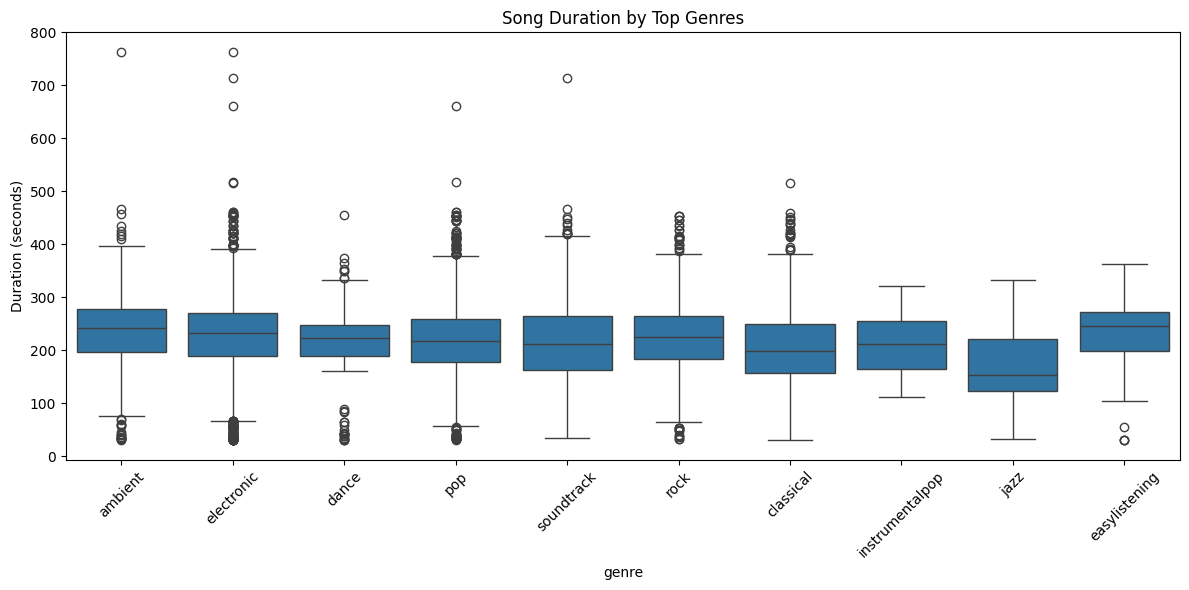

In [ ]:
# Explode genre
df_exploded = df.explode('genre')
top_genres = df_exploded['genre'].value_counts().head(10).index
df_top_genres = df_exploded[df_exploded['genre'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_genres, x='genre', y='duration_sec')
plt.title("Song Duration by Top Genres")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Genre Co-occurrence

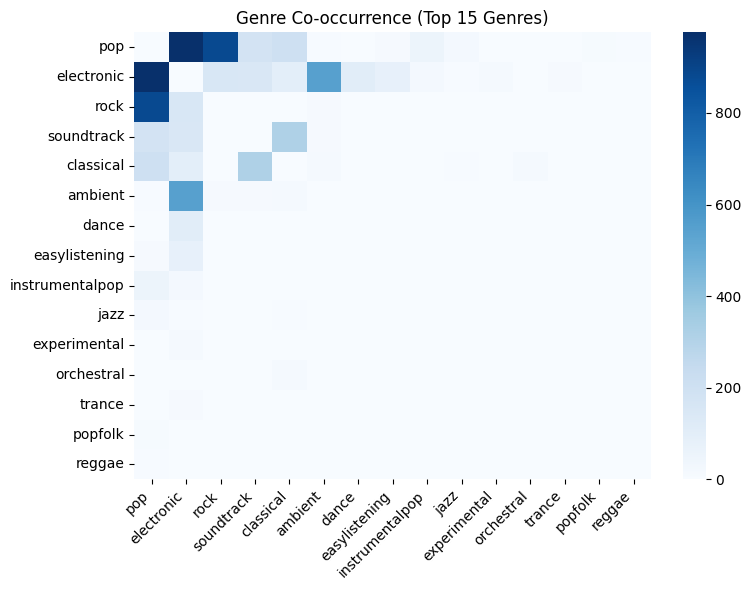

In [ ]:
# create top genres co-occurrence matrix
top_genres = df_exploded['genre'].value_counts().head(15).index
df['genre_top'] = df['genre'].apply(lambda g_list: [g for g in g_list if g in top_genres])
mlb = MultiLabelBinarizer(classes=top_genres)
genre_matrix = mlb.fit_transform(df['genre_top'])

# Co-occurrence matrix
co_occurrence = pd.DataFrame(genre_matrix, columns=mlb.classes_).T.dot(genre_matrix)
np.fill_diagonal(co_occurrence.values, 0)

# Plot with proper axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence, cmap="Blues", xticklabels=top_genres, yticklabels=top_genres)
plt.title("Genre Co-occurrence (Top 15 Genres)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Pitch for a few Songs

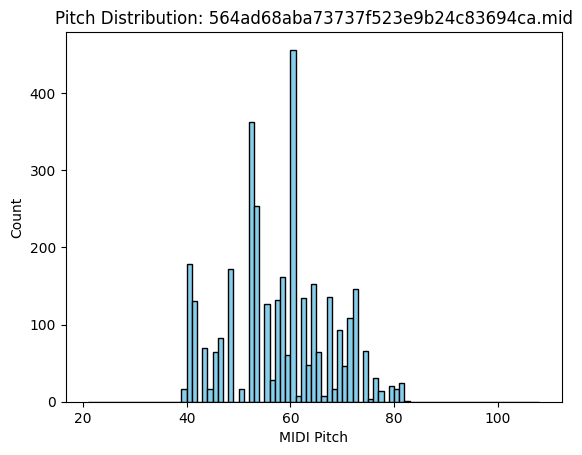

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


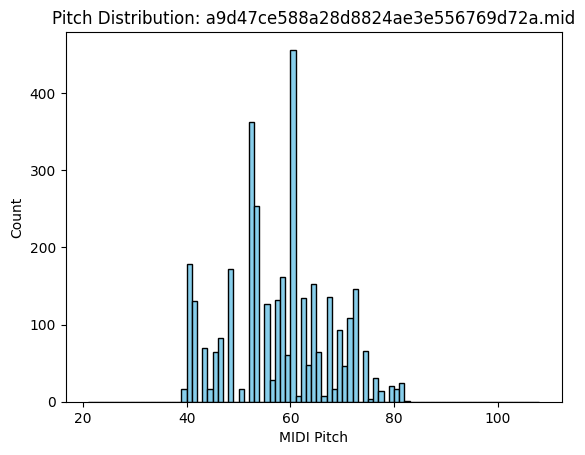

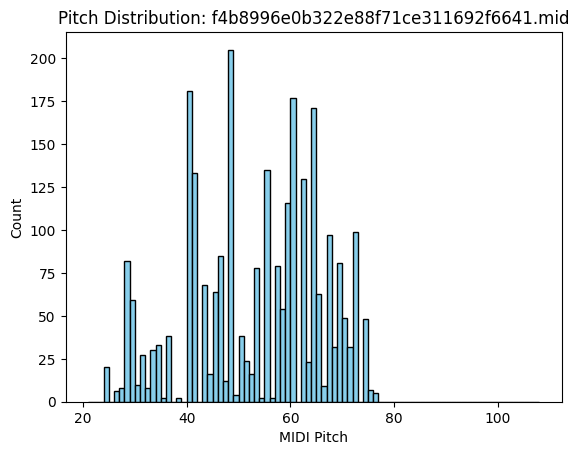

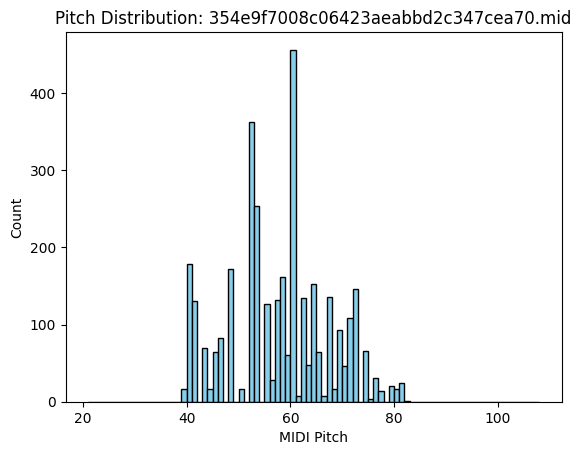

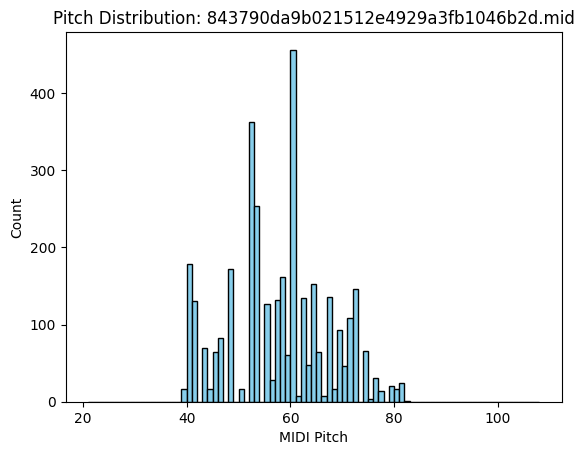

In [ ]:
def plot_pitch_histogram(midi_file):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        pitches = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    pitches.append(note.pitch)
        plt.hist(pitches, bins=np.arange(21, 109), color='skyblue', edgecolor='black')
        plt.title(f'Pitch Distribution: {os.path.basename(midi_file)}')
        plt.xlabel('MIDI Pitch')
        plt.ylabel('Count')
        plt.show()
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")

# Now plot only valid, usable files
for midi_file in midi_files[:5]:
    plot_pitch_histogram(midi_file)


# Next Steps
We should save the updated df with the new columns added to a new csv and call it `processed_midi.csv` or similar. Then use this as model input.